# <center> Train TrOCR on Steel Dataset </center>

## Preprocessing

### Load the model

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

checkpoint = "microsoft/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

### Load the data

In [2]:
from datasets import load_dataset

steel_data = load_dataset("cayjobla/iam-steel", split="train")

README.md:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11344 [00:00<?, ? examples/s]

In [3]:
# Split the dataset
steel_data = steel_data.train_test_split(test_size=0.2)
steel_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'english', 'steel'],
        num_rows: 9075
    })
    test: Dataset({
        features: ['image', 'label', 'english', 'steel'],
        num_rows: 2269
    })
})

smother his courtiers with flowers . nor was
smother his kortirs with flowers . nor was


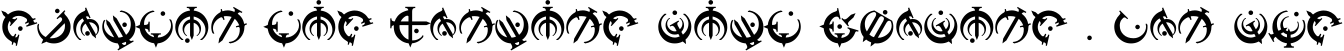

In [6]:
# Look at an example from the dataset
index = 2337
print(steel_data["train"][index]["english"])
print(steel_data["train"][index]["steel"])
display(steel_data["train"][index]["image"])

### Create a custom dataset for preprocessing

In [7]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SteelIAMDataset(Dataset):
    def __init__(self, data, processor, max_target_length=128):
        self._data = data
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        image = self._data[idx]["image"]
        text = self._data[idx]["english"]
        
        # Preprocessing
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(
            text, 
            padding="max_length",
            max_length=self.max_target_length,
            return_tensors="pt"
        ).input_ids

        # Ignore the padding tokens
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values.squeeze(), "labels": labels.squeeze()}

In [8]:
train_dataset = SteelIAMDataset(steel_data["train"], processor)
test_dataset = SteelIAMDataset(steel_data["test"], processor)

smother his courtiers with flowers . nor was


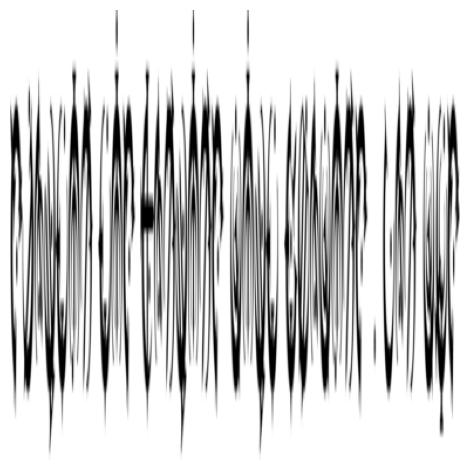

In [9]:
import torchshow

example = train_dataset[index]
pixel_values, labels = example["pixel_values"], example["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id   # Allow to decode
print(processor.decode(labels, skip_special_tokens=True))
torchshow.show(pixel_values)

## Prep for training

In [10]:
# Set special tokens
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
# NOTE: This is to downsample the data for testing
train_dataset = SteelIAMDataset(
    steel_data["train"].train_test_split(train_size=32)["train"], 
    processor
)
test_dataset = SteelIAMDataset(
    steel_data["test"].train_test_split(train_size=16)["train"], 
    processor
)

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=1,
    save_steps=500,
    eval_steps=500,
)

/home/yungdankblast/anaconda3/envs/ocr_translator/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
import evaluate

cer_metric = evaluate.load("cer")

In [14]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [15]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator
)

## Train

In [16]:
trainer.train()     # Training ran without errors!

Step,Training Loss,Validation Loss


/home/yungdankblast/anaconda3/envs/ocr_translator/lib/python3.11/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=12, training_loss=8.552176674207052, metrics={'train_runtime': 305.7224, 'train_samples_per_second': 0.314, 'train_steps_per_second': 0.039, 'total_flos': 7.183537833561293e+16, 'train_loss': 8.552176674207052, 'epoch': 3.0})

: 

In [ ]:
# TODO: Write training script and do a test run on the supercomputer